In [80]:
# data table manip
import pandas as pd
import numpy as np
from pandas_datareader import data, wb

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [81]:
# ======== clean csv files ========

# indicators csv (drops blank first row, gets rid of dt indicator columns, sets index to datetime)
indicators = pd.read_csv('Indicators_train.csv').iloc[1:].dropna(how='all')
indicators.date = pd.to_datetime(indicators.date)
for column in indicators:
    if 'dt' in column:
        del indicators[column]
    elif 'date' in column:
        continue
    else:
        indicators[column] = indicators[column].astype(float)
indicators = indicators.set_index(indicators.date)
del indicators['date']

# stock - csv (sets index to datetime)
stock = pd.read_csv('stocks-us-adjClose.csv')
stock.date = pd.to_datetime(stock.date)
stock = stock.set_index(stock.date)
del stock['date']

# sector - csv (loads csv and prints sectors for reference)
sector = pd.read_csv('Company_information.csv', encoding = "ISO-8859-1")
seclist = sector.Sector.unique()
sectorset = []
print('|',end='')
for member in seclist:
    if str(member) != 'nan':
        sectorset.append(member)
        print(member, end='|') 
        
# main sectors - csv
mainsectors = pd.read_csv('sector_ETFs.csv')
mainsectors['Date'] = pd.to_datetime(mainsectors['Date'])
mainsectors = mainsectors.set_index(mainsectors['Date'])
del mainsectors['Date']

|Utilities|Basic Materials|Consumer Goods|Industrial Goods|Healthcare|Services|Financial|Technology|Conglomerates|

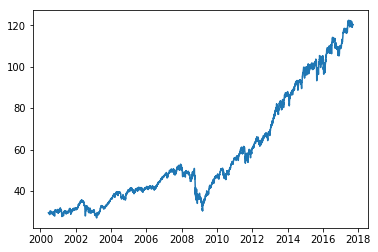

In [86]:
plt.plot(mainsectors['Consumer Goods (IYK)'])
plt.show()

In [84]:
# Merge sectors with indicators

sec_indic = pd.merge(mainsectors,indicators, how='inner', left_index=True, right_index=True).dropna(how='any')

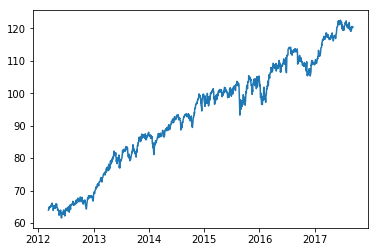

,Technology (IYW),Basic Materials (IYM),Consumer Goods (IYK),Services (IYC),Healthcare (IYH),Utilities (IDU),HOUST,UNRATENSA,EMRATIO,UEMPMED,UMCSENT,USSLIND,KCFSI,IPMAN,VIXCLS,DGS10
2017-09-05,147.656967,91.263222,120.192558,162.589981,168.935532,135.900024,1155.0,4.5,60.1,10.5,96.8,1.22,-0.73,104.1579,10.13,2.12
2017-09-05,147.656967,91.263222,120.192558,162.589981,168.935532,135.900024,1155.0,4.5,60.1,10.5,96.8,1.22,-0.73,104.1579,12.23,2.12
2017-09-06,147.955704,91.560776,120.400726,163.565002,169.720917,135.207962,1155.0,4.5,60.1,10.5,96.8,1.22,-0.73,104.1579,11.63,2.07
2017-09-07,148.423721,91.699638,120.509766,162.709366,171.331421,136.246048,1155.0,4.5,60.1,10.5,96.8,1.22,-0.73,104.1579,11.55,2.10
2017-09-08,147.039566,91.540939,120.301598,162.012939,172.077026,136.928207,1155.0,4.5,60.1,10.5,96.8,1.22,-0.73,104.1579,12.12,2.05


In [87]:
# data appears linear and not logarithmic
plt.plot(sec_indic['Consumer Goods (IYK)'])
plt.show()

sec_indic.tail()

In [88]:
sectors=['Technology (IYW)', 'Basic Materials (IYM)', 'Consumer Goods (IYK)', 'Services (IYC)', 'Healthcare (IYH)', 'Utilities (IDU)']
features=['HOUST', 'UNRATENSA', 'EMRATIO', 'UEMPMED',
       'UMCSENT', 'USSLIND', 'KCFSI', 'IPMAN', 'VIXCLS', 'DGS10']
sec_indic.corr()

# initiate empty dataframe
corr = pd.DataFrame()
for a in features:
    for b in sectors:
        corr.loc[a, b] = sec_indic.corr().loc[a, b]

corr

,Technology (IYW),Basic Materials (IYM),Consumer Goods (IYK),Services (IYC),Healthcare (IYH),Utilities (IDU)
HOUST,0.797791,0.623279,0.879068,0.875549,0.851387,0.837911
UNRATENSA,-0.896497,-0.704691,-0.947071,-0.950166,-0.940192,-0.914528
EMRATIO,0.932982,0.689036,0.927112,0.909311,0.877796,0.953048
UEMPMED,-0.892438,-0.692464,-0.950417,-0.953214,-0.947997,-0.911652
UMCSENT,0.840157,0.641928,0.868678,0.888639,0.889860,0.846299
USSLIND,0.268967,0.247243,0.292560,0.288182,0.322488,0.277312
KCFSI,-0.065771,-0.469777,-0.064606,-0.084982,-0.112565,0.015057
IPMAN,0.813431,0.582658,0.890537,0.904738,0.916923,0.839673
VIXCLS,-0.364619,-0.592054,-0.322849,-0.301993,-0.257019,-0.309225
DGS10,0.112172,0.402588,0.117935,0.168576,0.145435,-0.024464


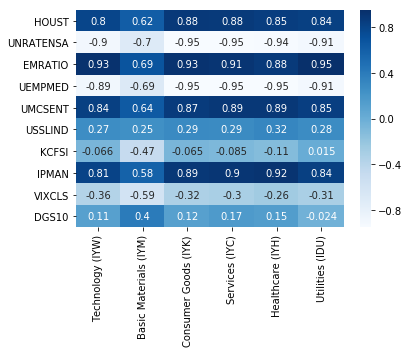

In [89]:
sns.heatmap(corr,cmap='Blues',annot=True)
plt.show()

# Correlations: Dark blue indicates strong correlation, White indicates strong inverse correlation

In [90]:
# choose variables
collist = ['EMRATIO','Utilities (IDU)']
xylist = ['x','y']

# Assigning Test and Training Data ranges
train_data = sec_indic['2010':'2017-05-29'][collist]
train_data.columns = xylist

test_data = sec_indic['2017-06-01':'2017-12-30'][collist]
test_data.columns = xylist

In [101]:
#Prints the Shape of a DataFrames after droping
print(test_data.shape)
print(train_data.shape)


#Creation of Linear Model Object
lm = LinearRegression()

#Slicing of Datasets
x_train = pd.DataFrame(train_data.iloc[:,0].values)
y_train = pd.DataFrame(train_data.iloc[:,1].values)

x_test = pd.DataFrame(test_data.iloc[:,0].values)
y_test = pd.DataFrame(test_data.iloc[:,1].values)

#Training the Model by training dataset
lm.fit(x_train,y_train)

#Prints the Accuracy of Model
accuracy = round(lm.score(x_train,y_train) *100,2)
print('Accuracy:', accuracy)

#Prints the Coefficients
print('Coefficients', lm.coef_)

#Estimated prediction of y_test values based on trained model
test_data['y_predict'] = lm.predict(x_test)



(72, 3)
(1344, 2)
Accuracy: 89.03
Coefficients [[ 31.56643518]]


In [102]:
test_data['2017-07'].tail()

,x,y,y_predict
2017-07-25,60.1,130.314148,127.977136
2017-07-26,60.1,131.253357,127.977136
2017-07-27,60.1,131.609268,127.977136
2017-07-28,60.1,131.411530,127.977136
2017-07-31,60.1,131.856430,127.977136


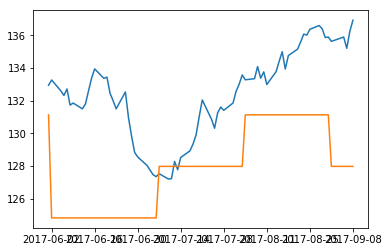

In [103]:
lines = ['y', 'y_predict']

plt.plot(test_data[lines])
plt.show()

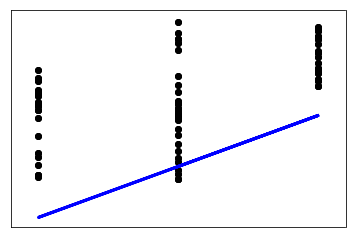